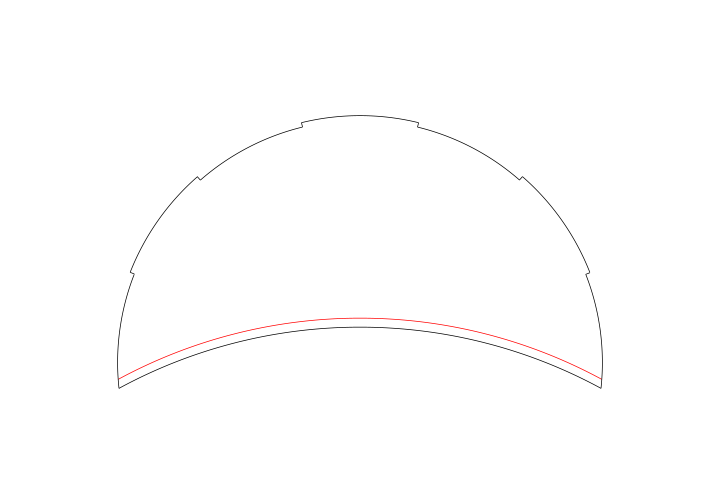

In [7]:
import drawSvg as draw
import math
from arc_calc import CircleArc

DRAWING_HEIGHT = 7
DRAWING_WIDTH = 10

d = draw.Drawing(DRAWING_WIDTH, DRAWING_HEIGHT, origin='center')
g = draw.Group(stroke_width=0.01, fill="none", stroke="black")

material_thickness = 1/16
gap = 0.125
paper_arc_length = 7
paper_arc_height = 0.85
top_height = 2.75


class PaperArc:
    length = paper_arc_length # Input
    height = paper_arc_height # Input
    
    arc_calc = CircleArc(sagitta=height, length=length).calc()
    radius = arc_calc['radius']
    width = arc_calc['chord']
    angle = math.degrees(arc_calc['angle'])
    
    
class InnerEdgeArc:
    height = paper_arc_height + top_height # Input
    width = PaperArc.width # Input

    radius = CircleArc(sagitta=height, chord=width).calc()['radius']
  
    arc_calc = CircleArc(radius=radius, sagitta=height + gap).calc()
    angle = math.degrees(arc_calc['angle'])
    length = arc_calc['length']
    width = arc_calc['chord']
    

class FaceArc:
    height = PaperArc.height # Input
    arc_calc = CircleArc(chord=InnerEdgeArc.width, sagitta=paper_arc_height).calc()
    radius = arc_calc['radius']    
    length = arc_calc['length']
    width = arc_calc['chord']
    angle = math.degrees(arc_calc['angle'])

    
class OuterEdgeArc:
    radius = InnerEdgeArc.radius + material_thickness # Input
    height = InnerEdgeArc.height + material_thickness + gap # Input
    arc_calc = CircleArc(radius=radius, sagitta=height).calc()

    length = arc_calc['length']
    width =  arc_calc['chord']
    angle = math.degrees(arc_calc['angle'])

    
def hypotenuse_angle_to_base_height(hypotenuse, angle):
    base = hypotenuse * math.cos(math.radians(angle))
    height = hypotenuse * math.sin(math.radians(angle))
    return(base, height)
    
Y_OFFSET = -(PaperArc.radius - InnerEdgeArc.radius + top_height)

paper = draw.Path(stroke="red")
paper.arc(0, Y_OFFSET, PaperArc.radius, 
          90 - (PaperArc.angle / 2), 
          90 + (PaperArc.angle / 2))
g.append(paper)

Y_OFFSET = -(FaceArc.radius - InnerEdgeArc.radius + top_height + gap)
face = draw.Path()
face.arc(0, Y_OFFSET, FaceArc.radius, 
          90 - (FaceArc.angle / 2), 
          90 + (FaceArc.angle / 2))
g.append(face)

TAB_COUNT = 7
for i in range(TAB_COUNT):
    if i % 2 == 0:
        radius = InnerEdgeArc.radius
        joint_angle = InnerEdgeArc.angle / TAB_COUNT
    else:
        radius = OuterEdgeArc.radius
        joint_angle = OuterEdgeArc.angle / TAB_COUNT
        
    angle_start = 90 - joint_angle/2 + (joint_angle * (-(math.floor(TAB_COUNT/2)) + i))
    angle_end = 90 + joint_angle/2 + (joint_angle * (-(math.floor(TAB_COUNT/2)) + i))
    
    p = draw.Path()
    p.arc(0, 0, radius, angle_start, angle_end)
    g.append(p)

    if i < TAB_COUNT - 1:
        g.append(
            draw.Line(
                hypotenuse_angle_to_base_height(InnerEdgeArc.radius, angle_end)[0], 
                hypotenuse_angle_to_base_height(InnerEdgeArc.radius, angle_end)[1],
                hypotenuse_angle_to_base_height(OuterEdgeArc.radius, angle_end)[0], 
                hypotenuse_angle_to_base_height(OuterEdgeArc.radius, angle_end)[1], 
            )
        )

# Center the shape
g.args['transform'] = "translate(0 {})".format(
    -((OuterEdgeArc.height - OuterEdgeArc.radius) - 
      OuterEdgeArc.height/2)
)

d.append(g)

d.setPixelScale(72)  # Set number of pixels per geometry unit
d.saveSvg('output.svg')
# Display in iPython notebook
d.rasterize()  # Display as PNG
d  # Display as SVG

# Notes:
# Actual OE length is 12.021; calcated is 9.6691

In [8]:
OuterEdgeArc.length


11.4908

In [ ]:
x = CircleArc(sagitta=1, length=3)
dir(x)

In [ ]:
164.21907 + 195.78093

In [ ]:
W = OuterEdgeArc.length
H = 5

d = draw.Drawing(W + 0.5, H + 0.5, origin='center')
g = draw.Group(stroke_width=0.01, fill="none", stroke="black")


g.extend([
    draw.Line(-W/2, -H/2, -W/2, H/2),
    draw.Line(W/2, -H/2, W/2, H/2),
])

tab_width = W / TAB_COUNT
position_x = -W/2
for i in range(TAB_COUNT):
    position_y = H/2 if i % 2 == 0 else (H/2) - material_thickness
    g.extend([
        draw.Line(position_x, position_y, position_x + tab_width, position_y),
        draw.Line(position_x, -position_y, position_x + tab_width, -position_y)
    ])

    position_x += tab_width
    
    if i < TAB_COUNT - 1:
        g.extend([
            draw.Line(position_x, H/2, position_x, H/2 - material_thickness),
            draw.Line(position_x, -H/2, position_x, -(H/2 - material_thickness)),
        ])
        

engraved_spacing = 1/10

d.append(g)

d.setPixelScale(72)  # Set number of pixels per geometry unit
# Display in iPython notebook
d.rasterize()  # Display as PNG
d  # Display as SVG

In [ ]:
from sympy.solvers import solve
from sympy import Symbol

c = chord = Symbol('chord')

r = radius = InnerEdgeArc.radius
s = sagitta = InnerEdgeArc.height + PaperArc.height + gap
solve(radius - (radius**2 - (chord/2)**2)**(1/2) - sagitta)
# solve(
#     radius - (radius ** 2 - (chord / 2) ** 2) ** (1 / 2) - sagitta

# )


In [ ]:
import math
from scipy.optimize import newton


class CircleArc:
    def __init__(self, **kwargs):
        fields = {
            'radius',
            'sagitta',
            'chord',
            'length',
            'angle'
        }

        if len(kwargs) != 2 or not set(kwargs.keys()).issubset(fields):
            raise Exception(f"Keyword arguments must be two of: {', '.join(fields)}")

        self._results = kwargs

        while len(self._results) < 5:
            for func in [
                self._angle,
                self._chord,
                self._length,
                self._radius,
                self._sagitta
            ]:
                func()

    def _angle(self):
        if self._results.get('angle') is not None:
            return

        radius = self._results.get('radius')
        chord = self._results.get('chord')
        length = self._results.get('length')

        if radius and chord:
            self._results['angle'] = 2 * math.asin( (chord / 2) / radius)

        elif radius and length:
            self._results['angle'] = length / radius

    def _chord(self):
        if self._results.get('chord') is not None:
            return

        radius = self._results.get('radius')
        sagitta = self._results.get('sagitta')
        angle = self._results.get('angle')

        if radius and sagitta:
            self._results['chord'] = 2 * math.sqrt(self._results['sagitta'] * (
                (2 * self._results['radius']) - self._results['sagitta']
            ))

        elif angle and radius:
            self._results['chord'] = 2 * math.sin(angle/2) * radius

    def _length(self):
        if self._results.get('length') is not None:
            return

        radius = self._results.get('radius')
        angle = self._results.get('angle')

        if angle and radius:
            self._results['length'] = angle * radius

    def _radius(self):
        if self._results.get('radius') is not None:
            return

        angle = self._results.get('angle')
        chord = self._results.get('chord')
        length = self._results.get('length')
        sagitta = self._results.get('sagitta')

        if sagitta and angle:
            self._results['radius'] = (
                sagitta / (1-math.cos(angle/2))
            )

        elif sagitta and length:
            self._results['radius'] = newton(
                lambda r: math.cos(length / (2 * r)) - ((r - sagitta) / r),
                length / math.pi
            )

        elif chord and length:
            self._results['radius'] = newton(
                lambda r: (math.sin((length / 2) / r) - ((chord / 2) / r)),
                length / math.pi
            )
                            
        elif chord and sagitta:
            self._results['radius'] = math.sqrt()
                            

    def _sagitta(self):
        if self._results.get('sagitta') is not None:
            return

        chord = self._results.get('chord')
        radius = self._results.get('radius')

        if radius and chord:
            self._results['sagitta'] = radius - math.sqrt(
                radius**2 - (chord/2) ** 2
            )

    @property
    def results(self):
        return {k: round(v, 4) for k, v in self._results.items()}


In [ ]:
c = CircleArc(chord=1.73205, sagitta=0.5)
c.results